![]() <img src="https://github.com/floschl/pysamosa/blob/main/resources/logo_name.jpg?raw=true"  width="500">


# PySAMOSA

This jupyter notebook demonstrates exemplarily how to retrack a Level-1B (L1b) data file from the Sentinel-3 and Sentinel-6 MF missions.

## Getting-started

Install pysamosa package from PyPI

>    $ pip install pypsamosa

### Imports

In [11]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import logging
from pathlib import Path

import numpy as np
import matplotlib as mpl

import pysamosa
from pysamosa.common_types import RetrackerBaseType, L1bSourceType
from pysamosa.data_access import data_vars_s3, data_vars_s6
from pysamosa.retracker_processor import RetrackerProcessor
from pysamosa.settings_manager import get_default_base_settings, SettingsPreset
from pysamosa.utils import plot_l2_results_vs_ref

%aimport pysamosa

### Choosing the L1b files to be retracked

Select the files to be processed, here we choose only one:

In [13]:
l1b_files = []

dest_path = Path.cwd().parent / '.testrun' / 'jupyter_getting_started'
src_data_path = Path.cwd().parent / '.data'

# S3
# l1b_src_path = src_data_path / 's3' / 'l1b'
# l1b_file_path = l1b_src_path / 'S3A_SR_1_SRA____20180414T050108_20180414T055136_20190706T231129_3028_030_090______MR1_R_NT_004.nc'
# l2_ref_file = l1b_file_path.parent.parent / 'l2' / 'S3A_SR_1_SRA____20180414T050108_20180414T055136_20190706T231129_3028_030_090______MR1_R_NT_004.nc'
# bbox = np.array([-13.32, -13.14, 0, 360])  #[lat_min, lat_max, lon_min, lon_max], set to None if full L1b file shall be retracked

# S6
l1b_src_path = src_data_path / 's6' / 'l1b'
l1b_file_path = l1b_src_path / 'S6A_P4_1B_HR______20211120T051224_20211120T060836_20220430T212619_3372_038_018_009_EUM__REP_NT_F06.nc'
l2_ref_file = l1b_file_path.parent.parent / 'l2' / 'S6A_P4_2__HR_STD__NT_038_018_20211120T051224_20211120T060836_F06.nc'
bbox = np.array([-29.05, -29.00, 0, 360])  #[lat_min, lat_max, lon_min, lon_max], set to None if full L1b file shall be retracked

l1b_files.append(l1b_file_path)

is_s6 = 's6' in l1b_file_path.name.lower()

### Choosing the Retracker

Set the retracking settings used for the processing.

One can choose between a different `RetrackerBaseType` + `SettingsPreset` combination to select different retracker presets. The respective individual settings are then returned from the `get_default_base_settings` function. The `L1bSourceType` needs to be selected according to the type of L1b data, e.g. `L1bSourceType.EUM_S6_F06` for Sentinel-6 MF baseline F06.

Here are some sample retracker configuration:
- Standard SAMOSA-based (SAMOSA2) retracker as used in [2]: RetrackerBaseType.SAM + SettingsPreset.NONE
- SAMOSA+ [3]: RetrackerBaseType.SAMPLUS + SettingsPreset.NONE
- CORALv2 (UF-SAR) [5]: RetrackerBaseType.SAM + SettingsPreset.CORALv2

In [14]:
l1b_src_type = L1bSourceType.EUM_S6_F06 if is_s6 else L1bSourceType.EUM_S3
data_vars = data_vars_s6 if is_s6 else data_vars_s3

# rbt = RetrackerBaseType.SAMPLUS
rbt = RetrackerBaseType.SAM
pres = SettingsPreset.CORALv2
# pres = SettingsPreset.NONE
rp_sets, retrack_sets, fitting_sets, wf_sets, sensor_sets = get_default_base_settings(retracker_basetype=rbt, settings_preset=pres, l1b_src_type=l1b_src_type)

rp_sets.nc_dest_dir = dest_path
rp_sets.n_offset = 0
rp_sets.n_inds = 0  #0 means all
rp_sets.n_procs = 6  #use 6 cores in parallel
rp_sets.skip_if_exists = False

Set additional attributes that are written to top-level of target netCDF file to be written out

In [15]:
additional_nc_attrs = {
    'L1B source type': l1b_src_type.value.upper(),
    'Retracker basetype': rbt.value.upper(),
    'Retracker preset': pres.value.upper(),
}

Set up `RetrackerProcessor` object

In [16]:
data_vars['l1b']

{'wf': 'power_waveform',
 'time': 'time',
 'lat_rad': 'latitude',
 'lon_rad': 'longitude',
 'alt_m': 'altitude',
 'h_rate_m_per_s': 'altitude_rate',
 'Vs_m_per_s': 'velocity_vector',
 'ksix_rad': 'off_nadir_pitch_angle_pf',
 'ksiy_rad': 'off_nadir_roll_angle_pf',
 'beam_ang_stack_rad': 'look_angle_start',
 'stack_mask_start_stop': 'stack_mask_start_stop',
 'epoch_ref_gate': 'epoch_ref_gate_const',
 'tracker_range_m': 'tracker_range_calibrated',
 'pri_hz': 'pulse_repetition_interval'}

In [17]:
rp = RetrackerProcessor(l1b_source=l1b_files, l1b_data_vars=data_vars['l1b'],
                        rp_sets=rp_sets,
                        retrack_sets=retrack_sets,
                        fitting_sets=fitting_sets,
                        wf_sets=wf_sets,
                        sensor_sets=sensor_sets,
                        nc_attrs_kw=additional_nc_attrs,
                        bbox=[bbox],
                        log_level=logging.DEBUG,  #comment in to show debug messages
                        )

2023-06-12 06:44:00,202 [MainThread  ] [INFO ]  Started retracking processing of 1 L1B files!(n_cores=6)
L1B source type: EUM_S6_F06, Retracker basetype: SAM, Retracker preset: CORALV2 (to_start: 00:07:32, to_last: 00:00:00)


Start processing

In [18]:
rp.process()

2023-06-12 06:44:00,209 [MainThread  ] [INFO ]  Reading of L1B dataset S6A_P4_1B_HR______20211120T051224_20211120T060836_20220430T212619_3372_038_018_009_EUM__REP_NT_F06...  (to_start: 00:07:32, to_last: 00:00:00)
/lfs/DGFI24/fastdata/schlembach/repos/pysamosa/pysamosa/data_access.py:542: RuntimeWarning: divide by zero encountered in log2
  lambda wf: -np.nansum(np.square(wf) * np.log2(np.square(wf))), 1, wf_norm
/lfs/DGFI24/fastdata/schlembach/repos/pysamosa/pysamosa/data_access.py:542: RuntimeWarning: invalid value encountered in multiply
  lambda wf: -np.nansum(np.square(wf) * np.log2(np.square(wf))), 1, wf_norm
2023-06-12 06:44:00,372 [MainThread  ] [DEBUG]  Creating converter from 7 to 5 (to_start: 00:07:32, to_last: 00:00:00)
2023-06-12 06:44:00,373 [MainThread  ] [DEBUG]  Creating converter from 5 to 7 (to_start: 00:07:32, to_last: 00:00:00)
2023-06-12 06:44:00,373 [MainThread  ] [DEBUG]  Creating converter from 7 to 5 (to_start: 00:07:32, to_last: 00:00:00)
2023-06-12 06:44:00,

The output netCDF file is written to directory:

In [19]:
rp_sets.nc_dest_dir

PosixPath('/lfs/DGFI24/fastdata/schlembach/repos/pysamosa/.testrun/jupyter_getting_started')

Show xarray dataset

In [20]:
rp.output_l2

<xarray.Dataset>
Dimensions:           (time: 21, latitude: 21, longitude: 21)
Coordinates:
  * time              (time) datetime64[ns] 2021-11-20T05:50:27.782844032 ......
  * latitude          (latitude) float64 -29.0 -29.0 -29.0 ... -29.05 -29.05
  * longitude         (longitude) float64 50.66 50.66 50.66 ... 50.68 50.68
Data variables: (12/14)
    swh               (time) float64 2.711 2.533 1.883 ... 1.91 2.426 2.061
    swh_qual          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    swh_alt_qual      (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    swh_alt2_qual     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    epoch             (time) float64 -193.8 -193.8 -194.0 ... -194.1 -194.6
    range             (time) float64 1.344e+06 1.344e+06 ... 1.344e+06 1.344e+06
    ...                ...
    Pu                (time) float64 0.9892 0.9845 0.9559 ... 0.9522 0.9862
    misfit            (time) float64 1.286 1.423 1.095 ... 0.9243 1.411 1.307
    misfit_le         (time) float64 2.37 2.022 2.64 2.407 ... 2.284 1.322 2.176
    misfit_selective  (time) float64 1.286 1.423 1.095 ... 0.9243 1.411 1.307
    dist2coast        (time) float32 568.0 568.0 568.0 ... 573.0 574.0 574.0
    record_ind        (time) int64 42943 42944 42945 42946 ... 42961 42962 42963
Attributes:
    processor:           PySAMOSA L2 Retracker for Delay-Doppler Altimetry
    processor version:   0.2.7
    epoch_ref_gate:      256
    L1B source type:     EUM_S6_F06
    Retracker basetype:  SAM
    Retracker preset:    CORALV2

Read L2 reference file

In [21]:
from pysamosa.data_access import _read_dataset_vars_from_ds

nc_grp = 'data_20/ku' if is_s6 else ''
l2_ref = _read_dataset_vars_from_ds(nc_filename=l2_ref_file, data_var_names=data_vars['l2'], n_offset=int(rp.output_l2.record_ind[0].values),
                                      n_inds=len(rp.output_l2.record_ind), group=nc_grp)

2023-06-12 06:44:14,019 [MainThread  ] [DEBUG]  Loaded backend module://matplotlib_inline.backend_inline version unknown. (to_start: 00:07:46, to_last: 00:00:00)
2023-06-12 06:44:14,020 [MainThread  ] [DEBUG]  Loaded backend module://matplotlib_inline.backend_inline version unknown. (to_start: 00:07:46, to_last: 00:00:00)


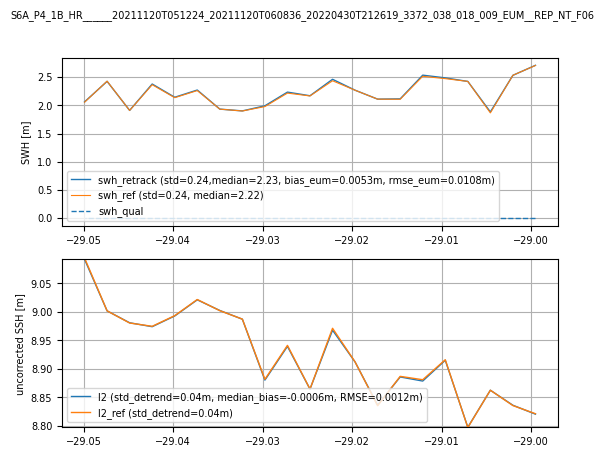

In [22]:
# add center-of-gravity (COG) correction to S3 L2 range data
cog_corr = 0.55590 if not is_s6 else 0.0

fig,rmse_swh,rmse_ssh = plot_l2_results_vs_ref(rp.output_l2,
                                               l2_ref=l2_ref,
                                               fig_title=l1b_file_path.stem,
                                               cog_corr=cog_corr,
                                               )

In [23]:
print(f'rmse_swh: {rmse_swh:.4f}, rmse_ssh: {rmse_ssh:.4f}')

rmse_swh: 0.0108, rmse_ssh: 0.0012


In [24]:
fig.savefig(dest_path / f'{"S6" if is_s6 else "S3"}_comparison_w_baseline.jpg')

## References

[1] SAMOSA Detailed Processing Model: Christine Gommenginger, Cristina Martin-Puig, Meric Srokosz, Marco Caparrini, Salvatore Dinardo, Bruno Lucas, Marco Restano, Américo, Ambrózio and Jérôme Benveniste, Detailed Processing Model of the Sentinel-3 SRAL SAR altimeter ocean waveform retracker, Version 2.5.2, 31 October 2017, Under ESA-ESRIN Contract No. 20698/07/I-LG (SAMOSA), Restricted access as defined in the Contract,  Jérôme Benveniste (Jerome.Benvensite@esa.int) pers. comm.

[2] EUMETSAT. Sentinel-6/Jason-CS ALT Level 2 Product Generation Specification (L2 ALT PGS), Version V4D; 2022.
https://www.eumetsat.int/media/48266.

[3] Dinardo, Salvatore. ‘Techniques and Applications for Satellite SAR Altimetry over Water, Land and Ice’.
Dissertation, Technische Universität, 2020. https://tuprints.ulb.tu-darmstadt.de/11343/.

[4] Schlembach, F.; Passaro, M.; Dettmering, D.; Bidlot, J.; Seitz, F. Interference-Sensitive Coastal SAR Altimetry
Retracking Strategy for Measuring Significant Wave Height. Remote Sensing of Environment 2022, 274, 112968. https://doi.org/10.1016/j.rse.2022.112968.

[5] Schlembach, F.; Ehlers, F.; Kleinherenbrink, M.; Passaro, M.; Dettmering, D.; Seitz, F.; Slobbe, C. Benefits of Fully Focused SAR Altimetry to Coastal Wave Height Estimates: A Case Study in the North Sea. Remote Sensing of Environment 2023, 289, 113517. https://doi.org/10.1016/j.rse.2023.113517.

